In [518]:
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import squarify
import matplotlib.patches as mpatches
import numpy as np

sys.path.append(os.path.abspath(".."))

from Data.DatabaseConnection import DatabaseConnection
dotenv_path = os.path.abspath("../.env")  
db = DatabaseConnection(dotenv_path)

In [519]:
units = db.get_all_units()
df = pd.DataFrame(units, columns=['id','match_id', 'puuid', 'character_id', 'rarity', 'tier'])
df.head()

,id,match_id,puuid,character_id,rarity,tier
0,1,EUN1_3778549380,teSxaW593i5isCS3TUX-dWR3JbmVaFZ0mc5bqkK1j-TtVn...,TFT14_NidaleeCougar,0,3
1,2,EUN1_3778549380,teSxaW593i5isCS3TUX-dWR3JbmVaFZ0mc5bqkK1j-TtVn...,TFT14_Kindred,0,3
2,3,EUN1_3778549380,teSxaW593i5isCS3TUX-dWR3JbmVaFZ0mc5bqkK1j-TtVn...,TFT14_Poppy,0,3
3,4,EUN1_3778549380,teSxaW593i5isCS3TUX-dWR3JbmVaFZ0mc5bqkK1j-TtVn...,TFT14_Veigar,1,3
4,5,EUN1_3778549380,teSxaW593i5isCS3TUX-dWR3JbmVaFZ0mc5bqkK1j-TtVn...,TFT14_Shyvana,1,3


In [520]:
df = df[df['character_id'].str.startswith('TFT14')]
df.head()

,id,match_id,puuid,character_id,rarity,tier
0,1,EUN1_3778549380,teSxaW593i5isCS3TUX-dWR3JbmVaFZ0mc5bqkK1j-TtVn...,TFT14_NidaleeCougar,0,3
1,2,EUN1_3778549380,teSxaW593i5isCS3TUX-dWR3JbmVaFZ0mc5bqkK1j-TtVn...,TFT14_Kindred,0,3
2,3,EUN1_3778549380,teSxaW593i5isCS3TUX-dWR3JbmVaFZ0mc5bqkK1j-TtVn...,TFT14_Poppy,0,3
3,4,EUN1_3778549380,teSxaW593i5isCS3TUX-dWR3JbmVaFZ0mc5bqkK1j-TtVn...,TFT14_Veigar,1,3
4,5,EUN1_3778549380,teSxaW593i5isCS3TUX-dWR3JbmVaFZ0mc5bqkK1j-TtVn...,TFT14_Shyvana,1,3


In [521]:
print(df.shape)
df.info()

(48052, 6)
<class 'pandas.core.frame.DataFrame'>
Index: 48052 entries, 0 to 55513
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            48052 non-null  int64 
 1   match_id      48052 non-null  object
 2   puuid         48052 non-null  object
 3   character_id  48052 non-null  object
 4   rarity        48052 non-null  int64 
 5   tier          48052 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 2.6+ MB


In [522]:
df.duplicated().sum()
df.isnull().sum()

id              0
match_id        0
puuid           0
character_id    0
rarity          0
tier            0
dtype: int64

In [523]:
df[df['tier'] > 3].shape[0]
df = df[df['tier'] <= 3]

In [524]:
df['champion'] = df['character_id'].str.replace(r'^TFT\d+_', '', regex=True)

In [525]:
players = db.get_all_players()
players_df = pd.DataFrame(players, columns=[
    'puuid', 'match_id', 'placement', 'level', 'gold_left', 'last_round',
    'players_eliminated', 'time_eliminated', 'total_damage', 'companion_id',
    'tier', 'division', 'leaguepoints', 'wins', 'losses'
])

df = df.merge(players_df, on=['match_id', 'puuid'], how='left')

print(df.columns)


Index(['id', 'match_id', 'puuid', 'character_id', 'rarity', 'tier_x',
       'champion', 'placement', 'level', 'gold_left', 'last_round',
       'players_eliminated', 'time_eliminated', 'total_damage', 'companion_id',
       'tier_y', 'division', 'leaguepoints', 'wins', 'losses'],
      dtype='object')


In [526]:
champion_summary = df.groupby(['champion', 'rarity']).size().reset_index(name='count')
champion_summary = champion_summary.sort_values(by='count', ascending=False)
champion_summary.head(10)


,champion,rarity,count
18,Jarvan,2,1533
28,Mordekaiser,2,1313
20,Jhin,1,1268
15,Gragas,2,1211
36,Rhaast,1,1172
38,Sejuani,4,1147
26,Leona,4,1140
8,DrMundo,0,1130
3,Aurora,6,1071
42,Shyvana,1,1071


/tmp/ipykernel_28559/442271327.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_champs['rarity_adjusted'] = top_champs['rarity'].apply(


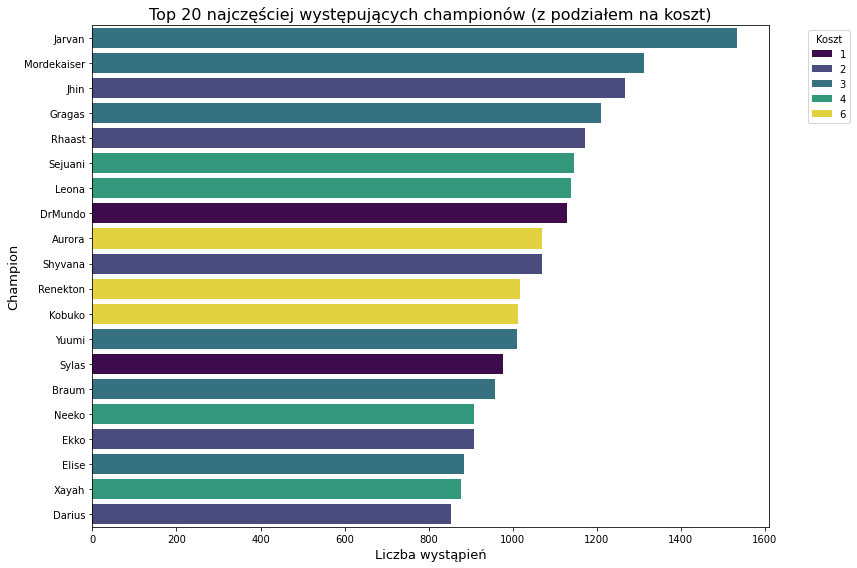

In [527]:
top_champs = champion_summary.head(20)

top_champs['rarity_adjusted'] = top_champs['rarity'].apply(
    lambda r: r + 1 if r in [0, 1, 2] else r
)

plt.figure(figsize=(12, 8))
sns.barplot(
    data=top_champs,
    y='champion',
    x='count',
    hue='rarity_adjusted',
    dodge=False,
    palette='viridis'
)

plt.title("Top 20 najczęściej występujących championów (z podziałem na koszt)", fontsize=16)
plt.xlabel("Liczba wystąpień", fontsize=13)
plt.ylabel("Champion", fontsize=13)
plt.legend(title="Koszt", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Wykres pokazuje 20 najczęściej wybieranych championów, wśród których dominują postacie takie jak Mordekaiser, Jarvan i Jhin. Ich popularność sugeruje, że są silni lub dobrze pasują do wielu kompozycji. Co ważne, pojawiają się tu zarówno tanie, jak i drogie jednostki, co oznacza, że gracze chętnie sięgają po kosztowniejsze postacie, jeśli są one efektywne. 

/tmp/ipykernel_28559/2723490405.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_champs['rarity_adjusted'] = top_champs['rarity'].apply(


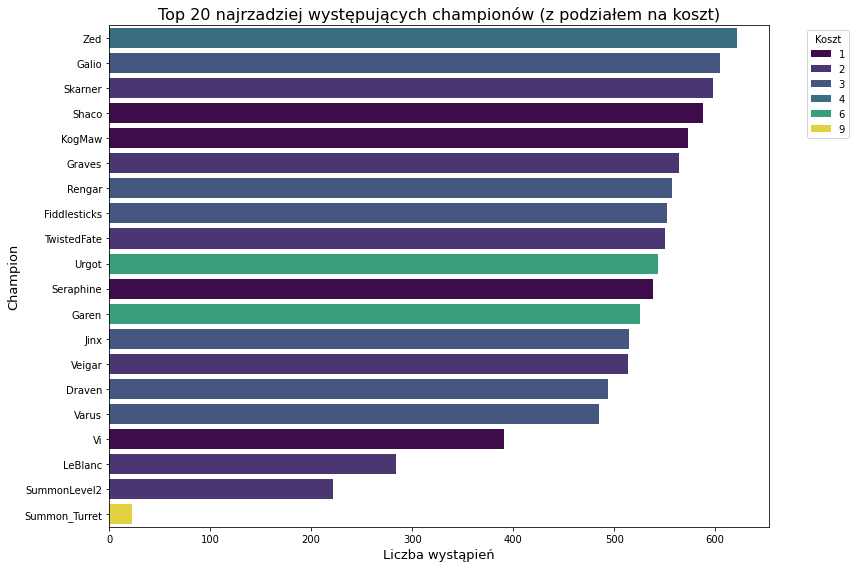

In [528]:
top_champs = champion_summary.tail(20)

top_champs['rarity_adjusted'] = top_champs['rarity'].apply(
    lambda r: r + 1 if r in [0, 1, 2] else r
)

plt.figure(figsize=(12, 8))
sns.barplot(
    data=top_champs,
    y='champion',
    x='count',
    hue='rarity_adjusted',
    dodge=False,
    palette='viridis'
)

plt.title("Top 20 najrzadziej występujących championów (z podziałem na koszt)", fontsize=16)
plt.xlabel("Liczba wystąpień", fontsize=13)
plt.ylabel("Champion", fontsize=13)
plt.legend(title="Koszt", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



Ten wykres przedstawia 20 najrzadziej wybieranych championów w grze. Wśród nich znajdują się głównie tanie jednostki (o niskim koszcie rarity), co może sugerować ich niską skuteczność lub ograniczoną przydatność w obecnej mecie. Na uwagę zasługuje obecność jednostek specjalnych, takich jak "Summon\_Turret" czy "Akali\_TrueDamage", które mogą być sytuacyjne lub unikalne. Te postacie wydają się mniej atrakcyjne dla graczy – być może przez słabe umiejętności, trudną dostępność lub niski wpływ na przebieg rozgrywki.

Wykres pokazuje, z jakimi jednostkami gracze kończą grę na 1. miejscu. Najwięcej z nich to postacie 2★, co sugeruje, że to one stanowią stabilną podstawę zwycięskich kompozycji. Gracze ulepszają jednostki 1★ do 2★, ale rzadziej inwestują dalej w poziom 3★. Może to wynikać z faktu, że zamiast skupiać się na maksymalnym ulepszaniu pojedynczych jednostek, gracze wolą rozbudowywać szerzej swoją kompozycję — rozwijać synergie (traits), kontrolować ekonomię i dostosowywać się do sytuacji w grze. W praktyce oznacza to, że 2★ to najbardziej efektywny i realistyczny poziom jednostki w drodze po zwycięstwo.

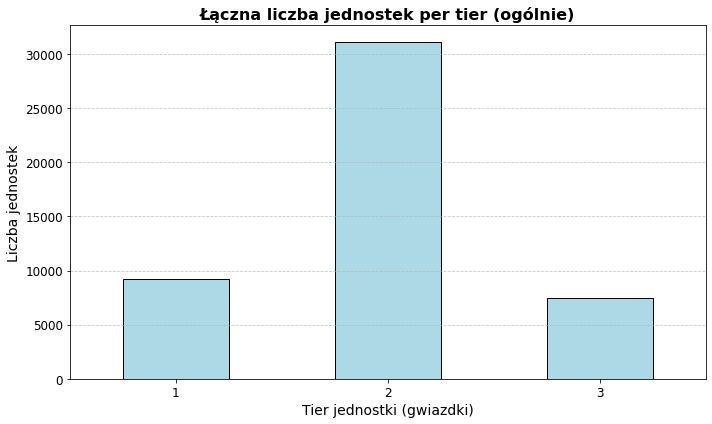

In [529]:
plt.figure(figsize=(10,6))

units_per_tier = df['tier_x'].value_counts().sort_index()

units_per_tier.plot(kind='bar', color='lightblue', edgecolor='black')
plt.title('Łączna liczba jednostek per tier (ogólnie)', fontsize=16, fontweight='bold')
plt.xlabel('Tier jednostki (gwiazdki)', fontsize=14)
plt.ylabel('Liczba jednostek', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


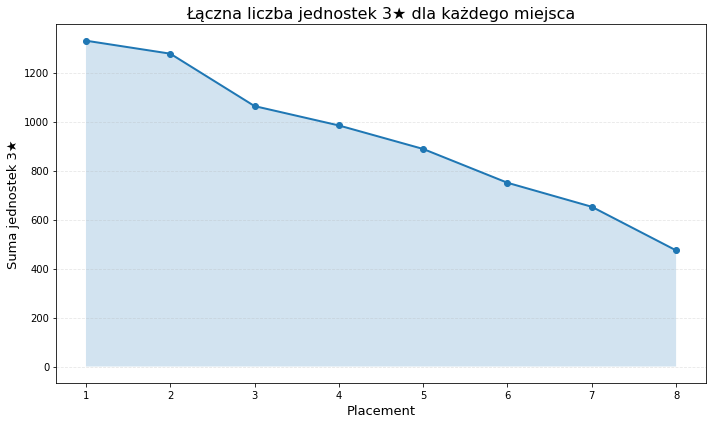

In [530]:
df['is_3star'] = df['tier_x'] == 3

three_star_counts = df[df['is_3star']].groupby(['match_id', 'puuid']).size().reset_index(name='three_star_count')

placement_df = df[['match_id', 'puuid', 'placement']].drop_duplicates()

merged = pd.merge(three_star_counts, placement_df, on=['match_id', 'puuid'], how='right').fillna(0)
merged['three_star_count'] = merged['three_star_count'].astype(int)
merged['placement'] = merged['placement'].astype(int)

sum_by_placement = merged.groupby('placement')['three_star_count'].sum().reset_index()
plt.figure(figsize=(10, 6))
plt.plot(sum_by_placement['placement'], sum_by_placement['three_star_count'], marker='o', linewidth=2)
plt.fill_between(sum_by_placement['placement'], sum_by_placement['three_star_count'], alpha=0.2)

plt.title("Łączna liczba jednostek 3★ dla każdego miejsca", fontsize=16)
plt.xlabel("Placement", fontsize=13)
plt.ylabel("Suma jednostek 3★", fontsize=13)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.xticks(sum_by_placement['placement'])
plt.tight_layout()
plt.show()


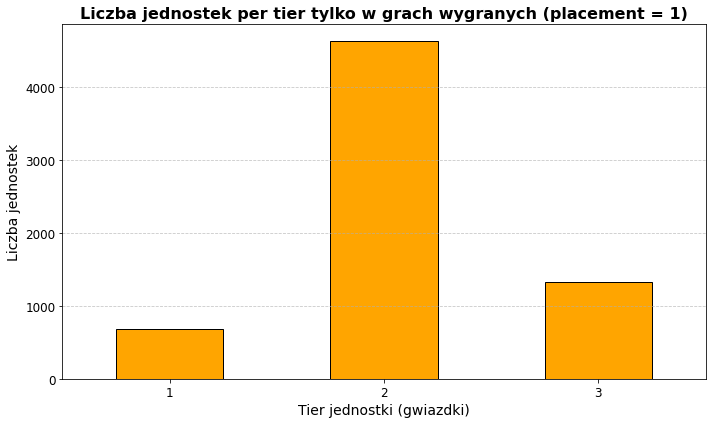

In [531]:
plt.figure(figsize=(10,6))

df_wins = df[df['placement'] == 1]

units_per_tier_wins = df_wins['tier_x'].value_counts().sort_index()

units_per_tier_wins.plot(kind='bar', color='orange', edgecolor='black')
plt.title('Liczba jednostek per tier tylko w grach wygranych (placement = 1)', fontsize=16, fontweight='bold')
plt.xlabel('Tier jednostki (gwiazdki)', fontsize=14)
plt.ylabel('Liczba jednostek', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Wykres przedstawia zależność między miejscem zajętym przez gracza a łączną liczbą posiadanych jednostek na poziomie 3★. Zauważalna jest wyraźna tendencja – im wyższe miejsce, tym więcej graczy miało jednostki na maksymalnym poziomie.

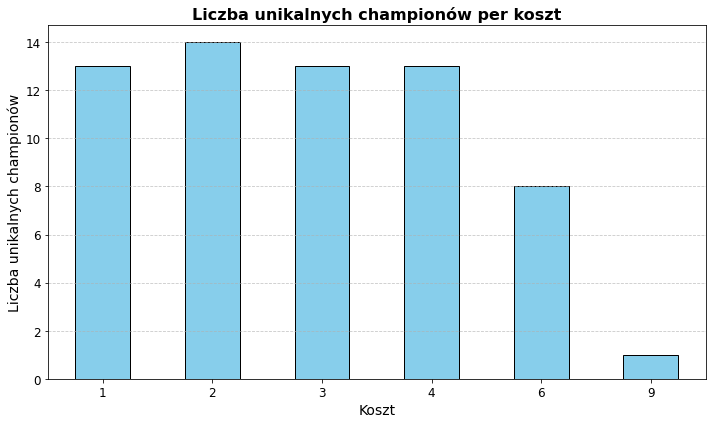

In [532]:
plt.figure(figsize=(10,6))

df['rarity_display'] = df['rarity'].apply(lambda x: x+1 if x <=2 else x)

unique_champions_per_cost = df.groupby('rarity_display')['character_id'].nunique()

unique_champions_per_cost.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Liczba unikalnych championów per koszt', fontsize=16, fontweight='bold')
plt.xlabel('Koszt', fontsize=14)
plt.ylabel('Liczba unikalnych championów', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


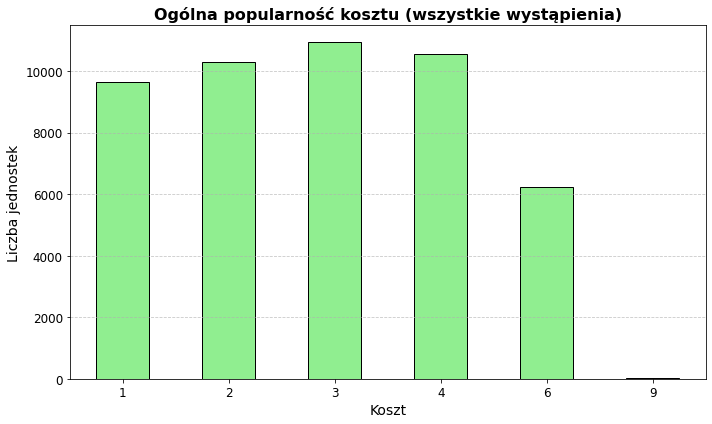

In [533]:
plt.figure(figsize=(10,6))
popularity_per_cost = df['rarity_display'].value_counts().sort_index()

popularity_per_cost.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Ogólna popularność kosztu (wszystkie wystąpienia)', fontsize=16, fontweight='bold')
plt.xlabel('Koszt', fontsize=14)
plt.ylabel('Liczba jednostek', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


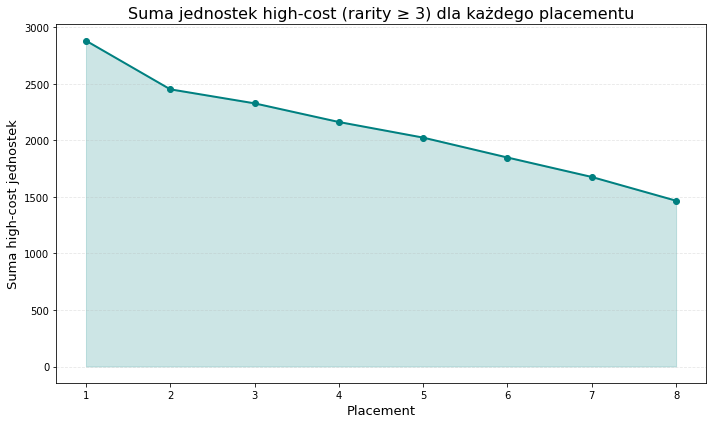

In [534]:
df['is_high_cost'] = df['rarity'] >= 3
high_cost_counts = df[df['is_high_cost']].groupby(['match_id', 'puuid']).size().reset_index(name='high_cost_count')

placement_df = df[['match_id', 'puuid', 'placement']].drop_duplicates()
merged_high_cost = pd.merge(high_cost_counts, placement_df, on=['match_id', 'puuid'], how='right').fillna(0)
merged_high_cost['high_cost_count'] = merged_high_cost['high_cost_count'].astype(int)
merged_high_cost['placement'] = merged_high_cost['placement'].astype(int)

sum_high_cost = merged_high_cost.groupby('placement')['high_cost_count'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(sum_high_cost['placement'], sum_high_cost['high_cost_count'], marker='o', linewidth=2, color='teal')
plt.fill_between(sum_high_cost['placement'], sum_high_cost['high_cost_count'], alpha=0.2, color='teal')

plt.title("Suma jednostek high-cost (rarity ≥ 3) dla każdego placementu", fontsize=16)
plt.xlabel("Placement", fontsize=13)
plt.ylabel("Suma high-cost jednostek", fontsize=13)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.xticks(sum_high_cost['placement'])
plt.tight_layout()
plt.show()


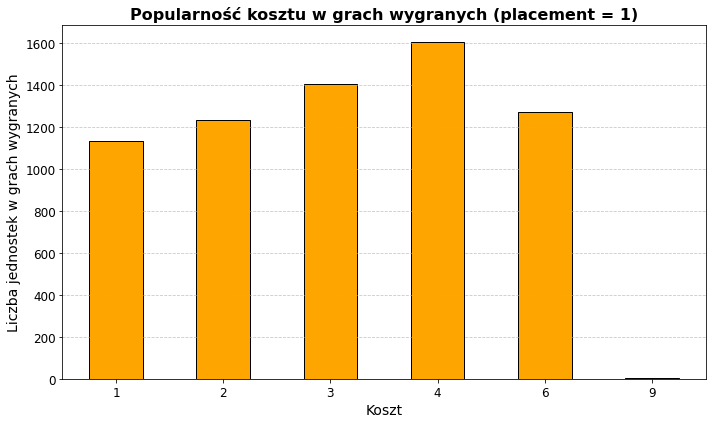

In [535]:
plt.figure(figsize=(10,6))
df_wins = df[df['placement'] == 1]
wins_per_cost = df_wins['rarity_display'].value_counts().sort_index()

wins_per_cost.plot(kind='bar', color='orange', edgecolor='black')
plt.title('Popularność kosztu w grach wygranych (placement = 1)', fontsize=16, fontweight='bold')
plt.xlabel('Koszt', fontsize=14)
plt.ylabel('Liczba jednostek w grach wygranych', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Wykres pokazuje łączną liczbę jednostek high-cost (koszt ≥ 3), używanych przez graczy na różnych miejscach. Widać wyraźnie, że najlepsi gracze (1–3 miejsce) znacznie częściej korzystają z droższych jednostek. Sugeruje to, że dostęp do high-cost championów może być istotnym czynnikiem wpływającym na końcowy sukces w grze.

In [ ]:
total_champ_counts = df.groupby('champion').size().reset_index(name='total_count')

win_champ_counts = df[df['placement'] == 1].groupby('champion').size().reset_index(name='win_count')

champ_winrate = pd.merge(total_champ_counts, win_champ_counts, on='champion', how='left').fillna(0)
champ_winrate['winrate'] = champ_winrate['win_count'] / champ_winrate['total_count']

rarity_map = df[['champion', 'rarity']].drop_duplicates()
champ_winrate = pd.merge(champ_winrate, rarity_map, on='champion', how='left')

top_champ_winrate = champ_winrate.sort_values(by='winrate', ascending=False).head(30)

plt.figure(figsize=(14, 9))
sns.barplot(
    data=top_champ_winrate,
    x='winrate',
    y='champion',
    hue='rarity',
    dodge=False,
    palette='viridis'
)

plt.title("Top 30 championów wg winrate", fontsize=18, fontweight='bold')
plt.xlabel("Winrate (procent zwycięskich wystąpień)", fontsize=14)
plt.ylabel("Champion", fontsize=14)
plt.legend(title="Koszt jednostki (rarity)", bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=12, title_fontsize=13)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

ValueError: Could not interpret value `rarity_display` for `hue`. An entry with this name does not appear in `data`.

<Figure size 1008x648 with 0 Axes>

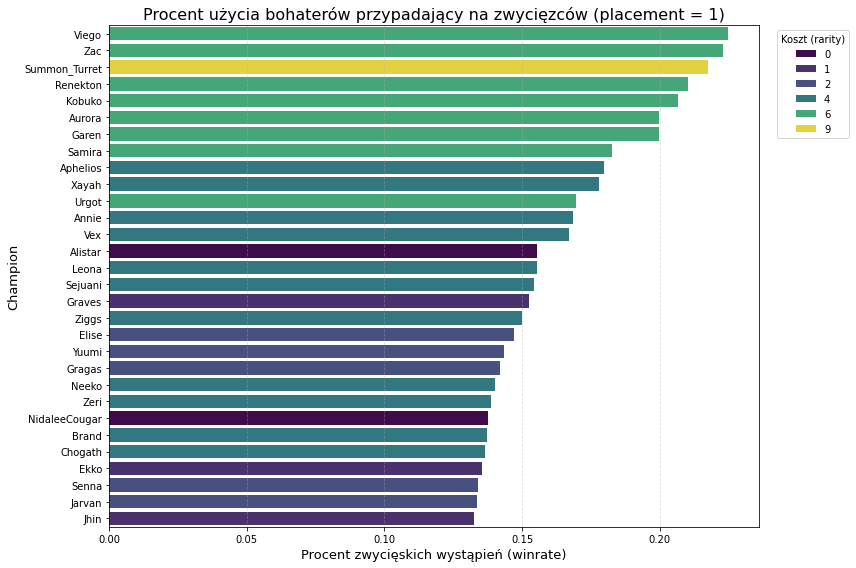

In [ ]:
total_champ_counts = df.groupby('champion').size().reset_index(name='total_count')

win_champ_counts = df[df['placement'] == 1].groupby('champion').size().reset_index(name='win_count')

champ_winrate = pd.merge(total_champ_counts, win_champ_counts, on='champion', how='left').fillna(0)
champ_winrate['winrate'] = champ_winrate['win_count'] / champ_winrate['total_count']
rarity_map = df[['champion', 'rarity']].drop_duplicates()

champ_winrate = pd.merge(champ_winrate, rarity_map, on='champion', how='left')

top_champ_winrate = champ_winrate.sort_values(by='winrate', ascending=False).head(30)

plt.figure(figsize=(12, 8))
sns.barplot(
    data=top_champ_winrate,
    x='winrate',
    y='champion',
    hue='rarity',
    dodge=False,
    palette='viridis'
)

plt.title("Procent użycia bohaterów przypadający na zwycięzców (placement = 1)", fontsize=16)
plt.xlabel("Procent zwycięskich wystąpień (winrate)", fontsize=13)
plt.ylabel("Champion", fontsize=13)
plt.legend(title="Koszt (rarity)", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


Ten wykres przedstawia, jaki procent wszystkich wystąpień danego bohatera przypada na graczy, którzy zajęli 1. miejsce (czyli tzw. "winrate jednostki"). Najwyżej są się postacie takie jak Corki i Kayn, które – mimo że nie należą do najdroższych – często pojawiają się u zwycięzców. Zaskakujący jest Summon_Turret, który pomimo rzadkości (koszt 9), pojawia się wyjątkowo często w zwycięskich kompozycjach.
Warto też zauważyć, że wiele tanich jednostek (koszt 1–2) również ma wysoki udział w zwycięskich teamach co może wynikać z ich dostępności

W treemapie widać, że gracze z top 3 najczęściej korzystają z jednostek o koszcie 2 i 4, co sugeruje, że są one fundamentem skutecznych kompozycji. Co ciekawe, większość tych championów osiąga poziom 2★, co oznacza, że są ulepszani, ale rzadko maksowani do 3★. Jednostki z kosztu 6 (najdroższe) również są obecne w dużej ilości i osiągają 2★. Z kolei tanie jednostki (koszt 0–1) pojawiają się rzadziej i zwykle w roli uzupełniającej.

tier_y
GOLD           8515
PLATINUM       7942
DIAMOND        6975
SILVER         6966
EMERALD        5982
UNRANKED       4999
BRONZE         3685
MASTER         1806
IRON            769
GRANDMASTER      72
CHALLENGER       22
Name: count, dtype: int64


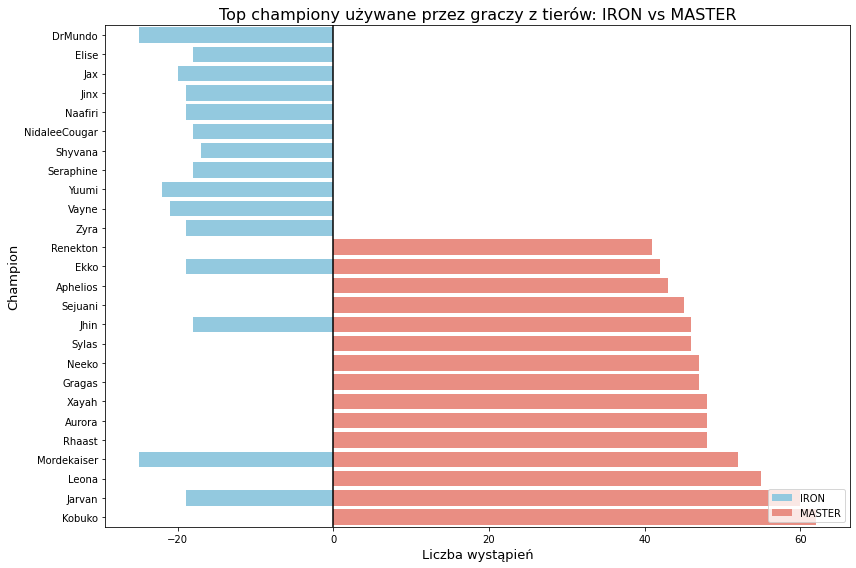

In [ ]:
print(df['tier_y'].value_counts())

tier_low = 'IRON'
tier_high = 'MASTER'

low_tier_df = df[df['tier_y'] == tier_low]
high_tier_df = df[df['tier_y'] == tier_high]

top_low = low_tier_df['champion'].value_counts().head(15).reset_index()
top_low.columns = ['champion', 'count_low']

top_high = high_tier_df['champion'].value_counts().head(15).reset_index()
top_high.columns = ['champion', 'count_high']

merged_tiers = pd.merge(top_low, top_high, on='champion', how='outer').fillna(0)

merged_tiers['count_low'] = -merged_tiers['count_low']

merged_tiers = merged_tiers.sort_values(by='count_high', ascending=True)

plt.figure(figsize=(12, 8))

sns.barplot(data=merged_tiers, x='count_low', y='champion', color='skyblue', label=tier_low)

sns.barplot(data=merged_tiers, x='count_high', y='champion', color='salmon', label=tier_high)

plt.axvline(0, color='black')
plt.xlabel("Liczba wystąpień", fontsize=13)
plt.ylabel("Champion", fontsize=13)
plt.title(f"Top championy używane przez graczy z tierów: {tier_low} vs {tier_high}", fontsize=16)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()



Na wykresie widać wyraźny kontrast między tym, jakich championów wybierają gracze z tieru IRON, a jakich używają gracze z MASTER. Postacie takie jak Jarvan, Gragas, Rhaast czy Mordekaiser są bardzo popularne wśród graczy z MASTER, podczas gdy gracze z IRON praktycznie w ogóle po nie nie sięgają. Z drugiej strony, bohaterowie tacy jak DrMundo, Yuumi czy Seraphine pojawiają się głównie u graczy z najniższego poziomu i są zupełnie pomijani przez tych z wyższych tierów. Pokazuje to, że lepsi gracze znacznie częściej wybierają konkretne, silniejsze jednostki, co może być jednym z powodów ich sukcesu.

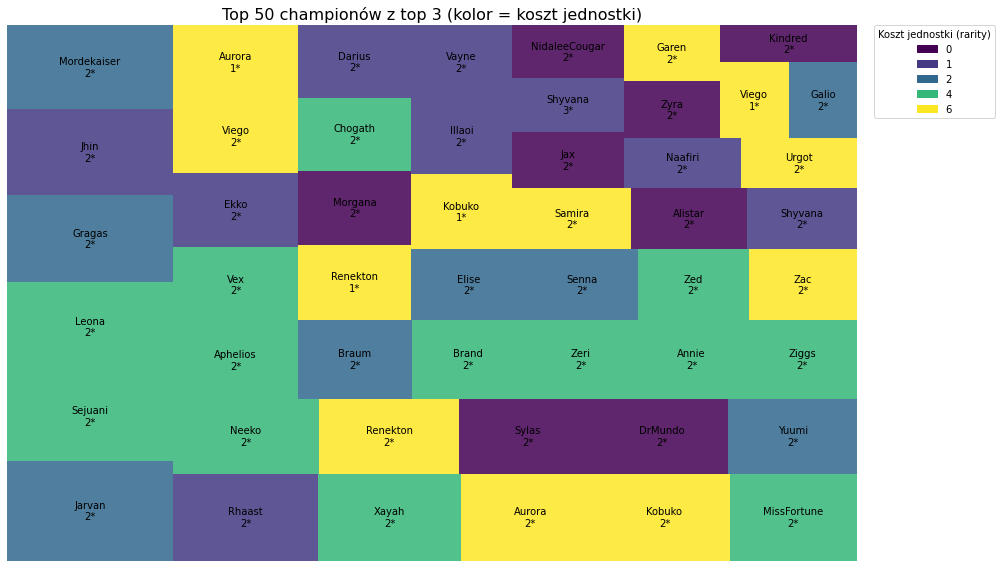

In [ ]:
top4_df = df[df['placement'] <= 3]

champ_table_top4 = top4_df.groupby(['champion', 'rarity', 'tier_x']).size().reset_index(name='count')

treemap_data = champ_table_top4.sort_values(by='count', ascending=False).head(50)

labels = [f"{row['champion']}\n{row['tier_x']}*" for _, row in treemap_data.iterrows()]

rarity = treemap_data['rarity']
colors = plt.cm.viridis(rarity / rarity.max())

fig, ax = plt.subplots(figsize=(14, 8))

squarify.plot(
    sizes=treemap_data['count'],
    label=labels,
    color=colors,
    alpha=0.85,
    ax=ax
)

plt.title("Top 50 championów z top 3 (kolor = koszt jednostki)", fontsize=16)
plt.axis('off')

unique_rarities = sorted(treemap_data['rarity'].unique())
legend_colors = [plt.cm.viridis(r / rarity.max()) for r in unique_rarities]
legend_labels = [str(r) for r in unique_rarities]
patches = [mpatches.Patch(color=c, label=l) for c, l in zip(legend_colors, legend_labels)]

plt.legend(
    handles=patches,
    title='Koszt jednostki (rarity)',
    loc='upper left',
    bbox_to_anchor=(1.02, 1),
    borderaxespad=0
)

plt.tight_layout()
plt.show()
